In [1]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.visualization.stretch import SinhStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
from astropy.utils import data
#from cycler import cycler
#from itertools import cycle
from scipy.stats import ks_2samp
from scipy.optimize import fsolve
from spectral_cube import Projection
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from scipy.interpolate import interp1d
from astropy.convolution import Gaussian1DKernel

fatal: detected dubious ownership in repository at '/blue/adamginsburg/adamginsburg/repos/dask'
To add an exception for this directory, call:

	git config --global --add safe.directory /blue/adamginsburg/adamginsburg/repos/dask


In [2]:
import warnings

def fxn():
    warnings.warn("WCSWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Data

In [3]:
a_fixednames =['/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.12CO.spw17.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.Ha.spw19.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.CH3OH.spw21.fits',
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw23.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw25.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.SiO.spw27.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.13CO.spw29.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.C18O.spw31.fits' 
               ]
cube_17 = SpectralCube.read(a_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_21 = SpectralCube.read(a_fixednames[2]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_23 = SpectralCube.read(a_fixednames[3]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_25 = SpectralCube.read(a_fixednames[4]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_27 = SpectralCube.read(a_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_29 = SpectralCube.read(a_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_31 = SpectralCube.read(a_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')


In [4]:
def noise_mask(cube, vmin, vmax, level):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def noise_mask_slab(cube, vmin, vmax, level, cut1, cut2):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.spectral_slab(cut1, cut2).max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

In [5]:
mask_17 = noise_mask(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_29 = noise_mask(cube_29, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_31 = noise_mask(cube_31, -100*u.km/u.second, -50 *u.km/u.second, 5)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out

# Cube Ratios

In [6]:
cube_17.shape

(2048, 63, 274)

In [7]:
cube_29.shape

(1024, 61, 262)

In [8]:
# cube.spectral_axis is np.arange(0,10,0.5) for this example
#new_axis = np.arange(0,10,2)*u.km/u.s
#fwhm_factor = np.sqrt(8*np.log(2))
#
#smcube = cube.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
#interp_Cube = smcube.spectral_interpolate(new_axis,
#                                          suppress_smooth_warning=True)

In [9]:
cube_29.spectral_axis

<Quantity [-120.03226323, -119.70016674, -119.36807026, ...,  219.0382489 ,
            219.37034539,  219.70244187] km / s>

In [10]:
fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = 0.159 * u.km/u.s
target_resolution = 0.332 * u.km/u.s
pixel_scale = 0.159 * u.km/u.s
gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  pixel_scale / fwhm_factor)
kernel = Gaussian1DKernel(gaussian_width.value)
smo_cube_17 = cube_17.spectral_smooth(kernel)

In [11]:
interp_cube17 = smo_cube_17.spectral_interpolate(cube_29.spectral_axis)

In [12]:
reproj_cube17 = interp_cube17.reproject(cube_29.header)

In [13]:
mask_rep17 = noise_mask(reproj_cube17, -100*u.km/u.second, -50 *u.km/u.second, 5)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


In [14]:
ratio_cube1729 = reproj_cube17.with_mask(mask_rep17) / cube_29.with_mask(mask_29)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.099e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.148e+03 [aplpy.core]


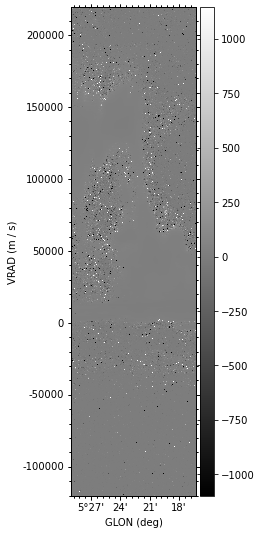

In [15]:
ratio_cube1729.mean(axis=1).quicklook()

In [16]:
0.016*5

0.08

In [17]:
#ratio_cube1729[ratio_cube1729<1] = 0
#tes_rat = np.zeros(ratio_cube1729.shape)
#tes_rat*(ratio_cube1729>0.08)
#ratio_cube1729 = ratio_cube1729.with_mask(ratio_cube1729>0.08).with_mask(ratio_cube1729<100)#.mean(axis=1).quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO: Auto-setting vmin to  9.675e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.628e-02 [aplpy.core]


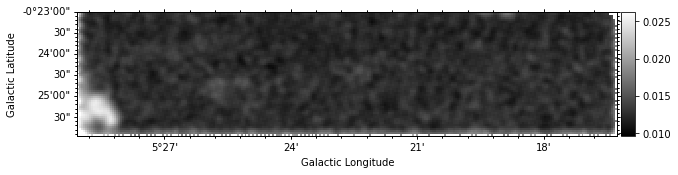

In [18]:
cube_17.spectral_slab(-100*u.km/u.second, -50*u.km/u.second).std(axis=0).quicklook()

INFO: Auto-setting vmin to -4.495e-02 [aplpy.core]
INFO: Auto-setting vmax to  4.298e-02 [aplpy.core]


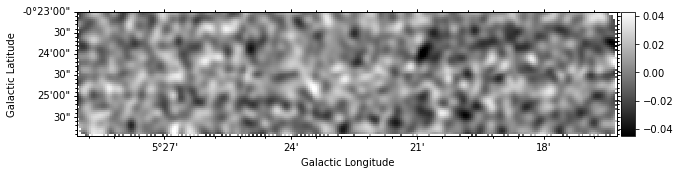

In [19]:
cube_17[201].quicklook()

# Interpolation

In [20]:
# Use linpace to find an array of observed ratios between 1-40
# interpolate
# make ratio cubes
# set tau = 0 when 13CO is not detected
# find that the pixels at ~10km/s are optically thick
# what fraction are at each optical depth? how much of the cloud is truly optically thin/thick?
# make a histogram of the tau values

In [21]:
def funct(tau, A): # = R
    #A = 30
    return (1-np.e**(-tau))/(1-np.e**(-tau/A))

def F_25(tau, R=20, A=25):
    return R - funct(tau, A)

def piecewise(slice17, slice29, inter, mini=1, maxi=25, std=0.05):
    gel = np.zeros(slice17.shape)
    for g in range(len(gel)):
        val = slice17[g] / slice29[g]
        if np.logical_or(np.less(slice17[g], std), np.less(slice29[g], std)):
            gel[g] = 0
        elif np.less(val, mini):
            gel[g] = 0
        elif np.greater(val, maxi):
            gel[g] = 0
        else:
            try:
                
                gel[g] = inter(val)
            except: 
                print(val)
                gel[g] = 0
    return gel

In [22]:
def reshape_arr(chan):
    s1 = chan.shape
    #print(s1)
    size = s1[0]*s1[1]
    reshaped = np.array(chan).reshape(size)
    s2 = reshaped.shape
    return reshaped#, s1
    #print(s2)
    #back_shape = reshaped.reshape(s1)
    #s3 = back_shape.shape
    #print(s3)
    #print(np.count_nonzero(chan-back_shape))
    #plt.imshow(chan-back_shape)
    #return (chan-back_shape)
    
def shape_back_arr(reshaped, s1):
    back_shape = reshaped.reshape(s1)
    return back_shape

## $^{12}C / ^{13}C$ = 25

In [23]:
R_25 = np.linspace(1, 25, num=100)
ones = np.ones(100)
tau_f25 = interp1d(R_25, fsolve(F_25, ones, args=(R_25, 25)))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [24]:
tau_f25([[25, 20], [2, 6]])

array([[-9.86926801e-08,  4.85305243e-01],
       [ 1.73816849e+01,  4.50476021e+00]])

In [25]:
#piecewise_25(np.array([2, 6]), tau_f25)

In [26]:
chan = np.array(ratio_cube1729.hdu.data)[100]

#for chan in range(ratio_cube1729.shape[0]): 
    #print(chan)
    

In [27]:
#plt.imshow(reshape_arr(chan))
#plt.colorbar()

In [28]:
ratio_cube1729.shape

(1024, 61, 262)

In [29]:
# ratio_cube1729 = reproj_cube17.with_mask(mask_rep17) / cube_29.with_mask(mask_29)

In [30]:
tau_cube = np.zeros(cube_29.shape)
cube_arr29 = np.array(cube_29.hdu.data)
cube_arr17 = np.array(reproj_cube17.hdu.data)
for ch in range(cube_29.shape[0]):
    chan29 = cube_arr29[ch]
    chan17 = cube_arr17[ch]
    long29 = reshape_arr(chan29)
    long17 = reshape_arr(chan17)
    tau_chan = piecewise(long17, long29, tau_f25, mini=1, maxi=25, std=0.05)
    tau_cube[ch] = shape_back_arr(tau_chan, chan29.shape)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.246e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.383e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.350e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.499e+01 [aplpy.core]


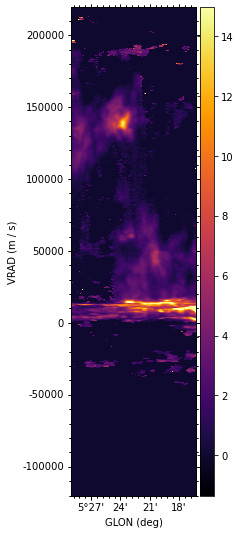

In [31]:
tau_spec_cube = SpectralCube(tau_cube, ratio_cube1729.wcs)
cu_mean = tau_spec_cube.max(axis=1)
cu_mean.quicklook()
cu_mean.FITSFigure.show_colorscale(cmap='inferno')
#plt.colorbar()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.420e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.577e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.489e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.652e+01 [aplpy.core]


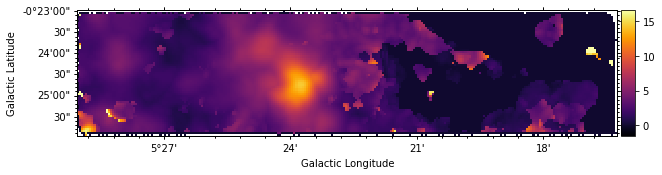

In [52]:
#plt.imshow(tau_spec_cube[500])
#plt.colorbar()
#print(tau_spec_cube.spectral_axis[500])
sli = tau_spec_cube.spectral_slab(100*u.km/u.second, 215*u.km/u.second).max(axis=0)#[805]
sli.quicklook()
sli.FITSFigure.show_colorscale(cmap='inferno')
#tau_spec_cube.spectral_axis[805].to(u.km/u.second)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.397e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.550e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.417e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.573e+01 [aplpy.core]


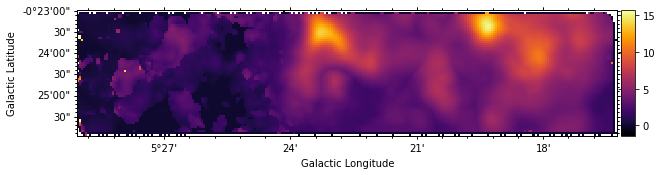

In [33]:
sli = tau_spec_cube.spectral_slab(15*u.km/u.second, 100*u.km/u.second).max(axis=0)#[805]
sli.quicklook()
sli.FITSFigure.show_colorscale(cmap='inferno')

In [53]:
#SpectralCube(tau_cube, ratio_cube1729.wcs).write('/orange/adamginsburg/cmz/g5/code/plots/tau_cube.fits', overwrite=True)

## $^{12}C / ^{13}C = 40$

In [35]:
R_40 = np.linspace(1, 40, num=500)
ones_40 = np.ones(500)
tau_f40 = interp1d(R_40, fsolve(F_25, ones_40, args=(R_40, 40)))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [36]:
tau_cube_40 = np.zeros(cube_29.shape)
cube_arr29 = np.array(cube_29.hdu.data)
cube_arr17 = np.array(reproj_cube17.hdu.data)
for ch in range(cube_29.shape[0]):
    chan29 = cube_arr29[ch]
    chan17 = cube_arr17[ch]
    long29 = reshape_arr(chan29)
    long17 = reshape_arr(chan17)
    tau_chan = piecewise(long17, long29, tau_f40, mini=1, maxi=40, std=0.05)
    tau_cube_40[ch] = shape_back_arr(tau_chan, chan29.shape)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.200e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.332e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.170e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.298e+01 [aplpy.core]


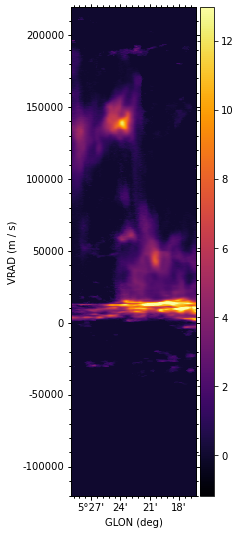

In [37]:
tau_spec_cube_40 = SpectralCube(tau_cube_40, cube_29.wcs)
cu_mean_40 = tau_spec_cube_40.mean(axis=1)
cu_mean_40.quicklook()
cu_mean_40.FITSFigure.show_colorscale(cmap='inferno')

In [54]:
#SpectralCube(tau_cube_40, ratio_cube1729.wcs).write('/orange/adamginsburg/cmz/g5/code/plots/tau_cube_40.fits', overwrite=True)

## $^{12}C / ^{13}C = 53$

In [39]:
R_53 = np.linspace(1, 53, num=500)
ones_53 = np.ones(500)
tau_f53 = interp1d(R_53, fsolve(F_25, ones_53, args=(R_53, 53)))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [40]:
tau_cube_53 = np.zeros(cube_29.shape)
cube_arr29 = np.array(cube_29.hdu.data)
cube_arr17 = np.array(reproj_cube17.hdu.data)
for ch in range(cube_29.shape[0]):
    chan29 = cube_arr29[ch]
    chan17 = cube_arr17[ch]
    long29 = reshape_arr(chan29)
    long17 = reshape_arr(chan17)
    tau_chan = piecewise(long17, long29, tau_f53, mini=1, maxi=53, std=0.05)
    tau_cube_53[ch] = shape_back_arr(tau_chan, chan29.shape)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.650e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.832e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.597e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.772e+01 [aplpy.core]


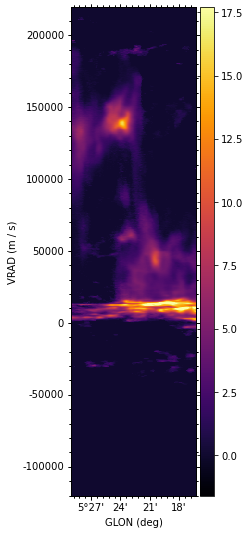

In [41]:
tau_spec_cube_53 = SpectralCube(tau_cube_53, ratio_cube1729.wcs)
cu_mean_53 = tau_spec_cube_53.mean(axis=1)
cu_mean_53.quicklook()
cu_mean_53.FITSFigure.show_colorscale(cmap='inferno')

In [55]:
#SpectralCube(tau_cube_53, ratio_cube1729.wcs).write('/orange/adamginsburg/cmz/g5/code/plots/tau_cube_53.fits', overwrite=True)

## $^{12}C / ^{13}C = 77$

In [43]:
R_77 = np.linspace(1, 77, num=500)
ones_77 = np.ones(500)
tau_f77 = interp1d(R_77, fsolve(F_25, ones_77, args=(R_77, 77)))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [44]:
tau_cube_77 = np.zeros(cube_29.shape)
cube_arr29 = np.array(cube_29.hdu.data)
cube_arr17 = np.array(reproj_cube17.hdu.data)
for ch in range(cube_29.shape[0]):
    chan29 = cube_arr29[ch]
    chan17 = cube_arr17[ch]
    long29 = reshape_arr(chan29)
    long17 = reshape_arr(chan17)
    tau_chan = piecewise(long17, long29, tau_f77, mini=1, maxi=77, std=0.05)
    tau_cube_77[ch] = shape_back_arr(tau_chan, chan29.shape)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.425e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.692e+01 [aplpy.core]
INFO: Auto-setting vmin to -2.321e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.576e+01 [aplpy.core]


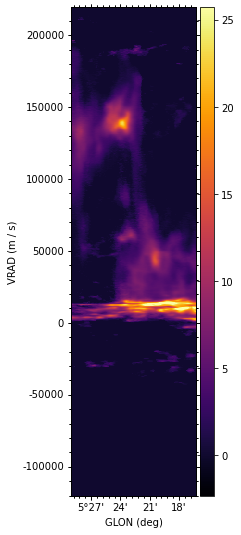

In [45]:
tau_spec_cube_77 = SpectralCube(tau_cube_77, ratio_cube1729.wcs)
cu_mean_77 = tau_spec_cube_77.mean(axis=1)
cu_mean_77.quicklook()
cu_mean_77.FITSFigure.show_colorscale(cmap='inferno')

In [56]:
#SpectralCube(tau_cube_77, ratio_cube1729.wcs).write('/orange/adamginsburg/cmz/g5/code/plots/tau_cube_77.fits', overwrite=True)

## $^{12}C / ^{13}C = 89$

In [47]:
R_89 = np.linspace(1, 89, num=500)
ones_89 = np.ones(500)
tau_f89 = interp1d(R_89, fsolve(F_25, ones_89, args=(R_89, 89)))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [48]:
tau_cube_89 = np.zeros(cube_29.shape)
cube_arr29 = np.array(cube_29.hdu.data)
cube_arr17 = np.array(reproj_cube17.hdu.data)
for ch in range(cube_29.shape[0]):
    chan29 = cube_arr29[ch]
    chan17 = cube_arr17[ch]
    long29 = reshape_arr(chan29)
    long17 = reshape_arr(chan17)
    tau_chan = piecewise(long17, long29, tau_f89, mini=1, maxi=89, std=0.05)
    tau_cube_89[ch] = shape_back_arr(tau_chan, chan29.shape)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.717e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.016e+01 [aplpy.core]
INFO: Auto-setting vmin to -2.663e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.956e+01 [aplpy.core]


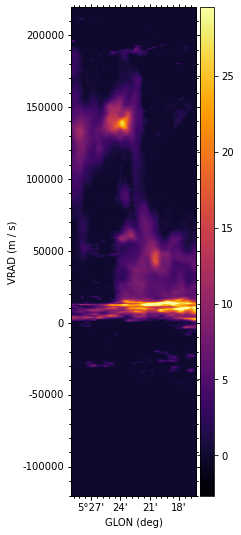

In [49]:
tau_spec_cube_89 = SpectralCube(tau_cube_89, ratio_cube1729.wcs)
cu_mean_89 = tau_spec_cube_89.mean(axis=1)
cu_mean_89.quicklook()
cu_mean_89.FITSFigure.show_colorscale(cmap='inferno')

In [57]:
#SpectralCube(tau_cube_89, ratio_cube1729.wcs).write('/orange/adamginsburg/cmz/g5/code/plots/tau_cube_89.fits', overwrite=True)

# Downsampling

In [51]:
# reproj_cube17.with_mask(mask_rep17) / cube_29.with_mask(mask_29)
# pixel size ~ resolution 
